## Neural Networks
1. [读取数据](#读取数据)
3. [构建模型](#构建模型)
4. [反向传播求梯度](#反向传播求梯度)
3. [梯度检验](#梯度检验)
4. [使用scipy.optimize优化算法训练](#使用scipy.optimize优化算法训练)
2. [可视化隐藏层参数](#可视化隐藏层参数)
4. [反向传播算法推导](#反向传播算法推导)
4. [Logistic Reression相关推导](#lr)

In [2]:
import numpy as np
import theano
import theano.tensor as T
import time
import scipy.io as sio
from scipy import optimize

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)


### 读取数据

In [3]:
data = sio.loadmat('ex3data1.mat')
X = data['X'].astype('float32') # (5000, 400)
Y = data['y'] # (5000, 1)
#Y = Y * (Y != 10) # 替换10为0
Y = Y - 1
Y = Y.reshape(5000, )
m, n = X.shape
num_labels = 10 # 10个类别

In [4]:
# 读取测试参数，same as matlab
dataTheta = sio.loadmat('ex3weights.mat')
dataTheta1 = dataTheta['Theta1'].astype('float32').T # (401, 25)
dataTheta2 = dataTheta['Theta2'].astype('float32').T # (26, 10)
dataThetaAll = np.hstack((dataTheta1.flatten(), dataTheta2.flatten()))

### 构建模型
![Network Structure](nn.png)

In [18]:
input_unit = n
hidden_unit = 25
output_unit = num_labels
lambdaVal = 0
softmax = False # 最后一层是否添加softmax计算类别概率

In [19]:
x = theano.shared(X, name='x') # (5000, 400)
output_unit = T.iscalar(name="output_unit")
hidden_unit = T.iscalar(name="hidden_unit")
lambdaVal = T.scalar(name='lambda')
num_samples, input_unit = x.shape

oy = theano.shared(Y, name='y') # (5000, )
oyy = T.cast(oy, 'int64') # indices need to be int type
gy = T.zeros([num_samples, output_unit], dtype='int32') # (5000, 10)
y = T.set_subtensor(gy[T.arange(num_samples), oyy[:]], 1) # 转成one-hot representation (0, 0,.., 1, 0, 0)，表示类别

theta = theano.shared(dataThetaAll, name='dataThetaAll') # 网络中所有的参数

# 提取出每一层网络中的参数
b1 = theta[0 : hidden_unit] # (25, )
theta1 = theta[hidden_unit : hidden_unit * (1 + input_unit)].reshape((input_unit, hidden_unit)) # (400, 25)
b2 = theta[hidden_unit * (1 + input_unit) : hidden_unit * (1 + input_unit) + output_unit] # (10, )
theta2 = theta[hidden_unit * (1 + input_unit) + output_unit : hidden_unit * (1 + input_unit) + output_unit * (1 + hidden_unit)] \
                .reshape((hidden_unit, output_unit)) # (25, 10)

# Feedforward propogation
z2 = T.dot(x, theta1) + b1 # (5000, 25)
a2 = T.nnet.sigmoid(z2) # (5000, 25)
z3 = T.dot(a2, theta2) + b2  # (5000, 10)

# regularization term
regTerm = (T.sum(theta1 ** 2) + T.sum(theta2 ** 2)) * lambdaVal / (2 * num_samples)  

if softmax == True: # 最后一层加softmax
    outputs = T.nnet.softmax(z3)
    # 使用这种最大化正确分类概率的形式时，上面需要接softmax，不能直接使用NN的输出值，否则效果差    
    loss = -T.mean(T.log(outputs)[T.arange(num_samples), oy])  + regTerm
    
    # 或使用自动求loss的函数
    # loss = T.nnet.categorical_crossentropy(outputs, oyy).mean()  + regTerm # oyy为 1-of-N vector
    # loss = T.nnet.categorical_crossentropy(outputs, y).mean() + regTerm  # y为  one-hot 2D tensor,这种精度更高，奇怪
    
else:  # 不加softmax
    outputs = T.nnet.sigmoid(z3)
    # 不接softmax的loss，不能使用softmax的那种loss形式，否则效果奇差，因为仅仅最大化正确分类的概率，不能保证其他类的概率最小化
    # 而softmax 的loss function则可以，因为所有类的概率和为1
    loss = -T.sum(y * T.log(outputs) + (1 - y) * T.log(1 - outputs)) / num_samples + regTerm
    # 或者自动求loss
    # loss = T.nnet.binary_crossentropy(outputs, y).mean() + regTerm

# predict
pred = T.argmax(outputs, 1) # (5000, )
total = T.eq(oy, pred)
accuracy = total.sum() / T.cast(num_samples, 'float32') # 分类准确率
calcAccur = theano.function([output_unit, hidden_unit], accuracy)

### 反向传播求梯度

In [20]:
# 手动求导
error3 = outputs - y # (5000, 10) 最后一层，不论是否加softmax，梯度都是这个形式
error2 = T.dot(error3, theta2.T) * a2 * (1 - a2) # (5000, 25)
delta2 = T.dot(a2.T, error3)  + lambdaVal * theta2 # (25, 10)  添加了正则项的导数部分
delta2_b = T.sum(error3, axis=0) # (10, )
delta1 = T.dot(x.T, error2) + lambdaVal * theta1 # (400, 25)
delta1_b = T.sum(error2, axis=0) # (25, )
theta_grad_mine = T.concatenate([T.flatten(delta1_b), T.flatten(delta1), T.flatten(delta2_b), T.flatten(delta2)]) / num_samples

# 自动求导
theta_grad = T.grad(loss, theta) 
calcLoss = theano.function([output_unit, hidden_unit, lambdaVal], loss, on_unused_input='warn')
calcGradAuto = theano.function([output_unit, hidden_unit, lambdaVal], theta_grad, on_unused_input='warn')
calcGrad = theano.function([output_unit, hidden_unit, lambdaVal], theta_grad_mine, on_unused_input='warn')

In [21]:
theta.set_value(dataThetaAll)
calcLoss(10, 25, 1) 

array(0.3837698542526638)

### 梯度检验
因为这里使用gpu进行运算, gpu内部使用float32数据类型, 所以精度较低, 在cpu中使用double则能看到更高的精度

In [11]:
def debugInitializeWeights(fan_out, fan_in):
    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))
    
    # Initialize W using "sin", this ensures that W is always of the same values and will be useful for debugging
    W = np.reshape(np.sin(1 + np.arange(np.size(W))), W.shape, order='F') / 10  # 注意F顺序
    return W.astype('float32')

def computeNumericalGradient(thetaVal, num_labels, hidden_layer_size, _lambda):
    numgrad = np.zeros_like(thetaVal)
    perturb = np.zeros_like(thetaVal)
    e = 1e-4
    for i in range(len(thetaVal)):
        perturb[i] = e
        theta.set_value(thetaVal - perturb)
        loss1 = calcLoss(num_labels, hidden_layer_size, _lambda)
        theta.set_value(thetaVal + perturb)
        loss2 = calcLoss(num_labels, hidden_layer_size, _lambda)
        # Compute Numerical Gradient
        numgrad[i] = (loss2 - loss1) / (2 * e)
        perturb[i] = 0
    return numgrad

def checkNNGradients():
    lambdaVal = 0
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size) # (5, 4)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size) # (3, 6)
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1) # (5, 3)
    Y  = np.mod(1 + np.arange(m), num_labels) # (5, )
    
    # Unroll parameters
    nn_params = np.hstack((Theta1.flatten(order='F'), Theta2.flatten(order='F'))) # 注意F顺序
    theta.set_value(nn_params)
    x.set_value(X)
    oy.set_value(Y.astype('uint8'))
    
    grad = calcGrad(num_labels, hidden_layer_size, lambdaVal)
    numgrad = computeNumericalGradient(nn_params, num_labels, hidden_layer_size, lambdaVal)

    grad.shape = -1, 1
    numgrad.shape = -1, 1
    # format numpy array print
    float_formatter = lambda x: "%.4f" % x
    np.set_printoptions(formatter={'float_kind':float_formatter})
    print np.hstack((numgrad, grad))
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print 'Relative Difference: %g' % diff
    
checkNNGradients()

[[-0.0096 -0.0093]
 [0.0089 0.0089]
 [-0.0083 -0.0084]
 [0.0076 0.0076]
 [-0.0068 -0.0067]
 [-0.0003 -0.0000]
 [0.0002 0.0000]
 [-0.0003 -0.0000]
 [0.0003 0.0000]
 [-0.0002 -0.0000]
 [0.0001 -0.0002]
 [0.0001 0.0002]
 [-0.0002 -0.0003]
 [0.0003 0.0003]
 [-0.0005 -0.0004]
 [0.0002 -0.0001]
 [0.0001 0.0001]
 [-0.0001 -0.0001]
 [0.0001 0.0002]
 [-0.0001 -0.0002]
 [0.3145 0.3145]
 [0.1112 0.1111]
 [0.0975 0.0974]
 [0.1643 0.1641]
 [0.0574 0.0576]
 [0.0505 0.0505]
 [0.1646 0.1646]
 [0.0580 0.0578]
 [0.0507 0.0508]
 [0.1582 0.1583]
 [0.0558 0.0559]
 [0.0492 0.0492]
 [0.1509 0.1511]
 [0.0539 0.0537]
 [0.0471 0.0471]
 [0.1497 0.1496]
 [0.0530 0.0532]
 [0.0464 0.0466]]
Relative Difference: 0.000926503


### 使用scipy.optimize优化算法训练

In [13]:
# 计算指定theta时的cost,使用optimize的函数时,传入的待优化参数是一个一维向量,所以要转成二维列向量,并且使用fmin时还需要转成float32类型
def computeCost(theta_value):
    theta.set_value(theta_value.astype('float32'))
    return calcLoss(10, 25, 1)

# 计算指定theta时的梯度
def train_fn_grad(theta_value):
    theta.set_value(theta_value.astype('float32'))
    return np.array(calcGrad(10, 25, 1)).flatten() # 梯度也要转为一维向量


def fitModel():
    # 使用共轭梯度法优化
    thetaV = [] # 存储每一次迭代后的结果
    thetaValue = optimize.fmin_cg( # or fmin_bfgs
        f=computeCost,
        x0=np.random.rand(401*25 + 26 * 10) * 2 * 0.12 - 0.12, # same as matlab
        fprime=train_fn_grad,
        disp=1,
        maxiter=50
    )
    return thetaValue


In [14]:
from scipy import optimize
x.set_value(X)
oy.set_value(Y)
theta.set_value(dataThetaAll)

start_time = time.time()
thetaValue = fitModel()
end_time = time.time()
print 'training cost %.2f s' % (end_time - start_time)
theta.set_value(thetaValue.astype('float32'))
print 'training set accuracy is %.2f ' % (calcAccur(10, 25)) # 100%

         Current function value: 0.444989
         Iterations: 50
         Function evaluations: 107
         Gradient evaluations: 107
training cost 1.97 s
training set accuracy is 0.96 


### 可视化隐藏层参数

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
# 画出数字
def displayData(X, example_width=-1):
    if example_width == -1:
        example_width = np.round(np.sqrt(X.shape[1])).astype('int8')
    # 计算每个小图的宽高
    m, n = X.shape
    example_height = (n / example_width)
    
    # 计算整个大拼图的宽高
    display_rows = np.floor(np.sqrt(m))
    display_cols = np.ceil(m / display_rows)
    
    #  小图之间的间隙
    pad = 1

    # 初始化大图矩阵
    display_array = -np.ones([pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)])
    # 装填图像矩阵
    curr_ex = 0
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))
            offset_row = int(pad + j * (example_height + pad))
            offset_col = int(pad + i * (example_width + pad))
            display_array[offset_row : offset_row + example_height,
                                     offset_col : offset_col + example_width] = np.reshape(X[curr_ex, :], [20, 20], order='F') / max_val # 按照Fortran顺序reshape(matlab也是按F顺序),或者按照默认的C顺序,然后转置
            curr_ex += 1
        if curr_ex >= m:
            break
    plt.imshow(display_array, cmap=plt.cm.binary_r)
    

/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


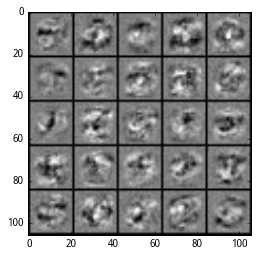

In [16]:
# 随机选择100个数字显示
t1 = theta1.eval({hidden_unit:25}).T
displayData(t1)

## 反向传播算法推导

假设我们有一个固定样本集 $\textstyle \{ (x^{(1)}, y^{(1)}), \ldots, (x^{(m)}, y^{(m)}) \}$，它包含 $\textstyle m $ 个样例。我们可以用批量梯度下降法来求解神经网络。具体来讲，对于单个样例 $\textstyle (x,y)$，其代价函数为：

$$
\begin{align}
J(W,b; x,y) = \frac{1}{2} \left\| h_{W,b}(x) - y \right\|^2.
\end{align}
$$

这是一个<span style="color:red">平方损失函数（最小二乘损失函数）</span>。给定一个包含 $ \textstyle m $ 个样例的数据集，我们可以定义整体代价函数为：

$$
\begin{align}
J(W,b)
&= \left[ \frac{1}{m} \sum_{i=1}^m J(W,b;x^{(i)},y^{(i)}) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
 \\
&= \left[ \frac{1}{m} \sum_{i=1}^m \left( \frac{1}{2} \left\| h_{W,b}(x^{(i)}) - y^{(i)} \right\|^2 \right) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
\end{align}
$$

以上公式中的第一项 $ \textstyle J(W,b) $ 是一个均方差项。第二项是一个正则项（也叫'''权重衰减项'''），其目的是减小权重的幅度，防止过度拟合。

'''权重衰减参数''' $ \textstyle \lambda $ 用于控制公式中两项的相对重要性。在此重申一下这两个复杂函数的含义：$ \color{red} {J(W,b;x,y)} $ 是针对单个样例计算得到的方差代价函数；$ \color{red} { J(W,b) }$ 是整体样本代价函数，它包含权重衰减项。

梯度下降法中每一次迭代都按照如下公式对参数 $ \textstyle W $ 和$ \textstyle b $ 进行更新：

$$
\begin{align}
W_{ij}^{(l)} &= W_{ij}^{(l)} - \alpha \frac{\partial}{\partial W_{ij}^{(l)}} J(W,b) \\
b_{i}^{(l)} &= b_{i}^{(l)} - \alpha \frac{\partial}{\partial b_{i}^{(l)}} J(W,b)
\end{align}
$$

我们首先来讲一下如何使用反向传播算法来计算 $ \textstyle \frac{\partial}{\partial W_{ij}^{(l)}} J(W,b; x, y)$ 和 $ \textstyle \frac{\partial}{\partial b_{i}^{(l)}} J(W,b; x, y) $，这两项是<span style="color:red">单个样例</span> $ \textstyle (x,y) $ 的代价函数 $ \textstyle J(W,b;x,y) $ 的偏导数。一旦我们求出该偏导数，就可以推导出整体代价函数 $ \textstyle J(W,b) $ 的偏导数：
$$
\begin{align}
\frac{\partial}{\partial W_{ij}^{(l)}} J(W,b) &=
\left[ \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial W_{ij}^{(l)}} J(W,b; x^{(i)}, y^{(i)}) \right] + \lambda W_{ij}^{(l)} \\
\frac{\partial}{\partial b_{i}^{(l)}} J(W,b) &=
\frac{1}{m}\sum_{i=1}^m \frac{\partial}{\partial b_{i}^{(l)}} J(W,b; x^{(i)}, y^{(i)})
\end{align}
$$
以上两行公式稍有不同，第一行比第二行多出一项，是因为权重衰减是作用于$ \textstyle W $ 而不是 $ \textstyle b $。

反向传播算法的思路如下：  
给定一个样例 $\textstyle (x,y)$，我们首先进行“前向传导”运算，计算出网络中所有的<span style="color:red">激活值$ z $</span>，包括 $\textstyle h_{W,b}(x)$ 的输出值。之后，针对第 $\textstyle l$ 层的每一个节点 $\textstyle i$，我们计算出其“残差” （或误差项）$\textstyle \delta^{(l)}_i$，该残差表明了该节点对最终输出值的残差（误差）产生了多少影响。对于最终的输出节点，我们可以直接算出网络产生的激活值与实际值之间的误差，我们将这个误差定义为 $\textstyle \delta^{(n_l)}_i$  （第 $\textstyle n_l$ 层表示输出层）。对于隐藏单元我们如何处理呢？我们将基于节点（译者注：第 $\textstyle l+1$ 层节点）残差的加权平均值计算 $\textstyle \delta^{(l)}_i$，这些节点以 $\textstyle a^{(l)}_i$ 作为输入。下面将给出反向传导算法的细节：  

<ol>
<li>进行前馈传导计算，利用前向传导公式，得到 $\textstyle L_2, L_3, \ldots $ 直到输出层 $\textstyle L_{n_l}$ 的激活值。
<li>对于第 $\textstyle n_l$ 层（输出层）的每个输出单元 $\textstyle i$，我们根据以下公式计算残差：


$$
\begin{align}
\delta^{(n_l)}_i
= \frac{\partial}{\partial z^{(n_l)}_i} \;\;
        \frac{1}{2} \left\|y - h_{W,b}(x)\right\|^2 = - (y_i - a^{(n_l)}_i) \cdot f'(z^{(n_l)}_i)
\end{align}
$$   
       
[译者注：
$$ 
\begin{align}
\delta^{(n_l)}_i &= \frac{\partial}{\partial z^{n_l}_i}J(W,b;x,y)
 = \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \left\|y - h_{W,b}(x)\right\|^2 \\
 &= \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}} (y_j-a_j^{(n_l)})^2
 = \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}} (y_j-f(z_j^{(n_l)}))^2 \quad (只有j=i项存在导数)\\
 &= - (y_i - f(z_i^{(n_l)})) \cdot f'(z^{(n_l)}_i)
 = - (y_i - a^{(n_l)}_i) \cdot f'(z^{(n_l)}_i)
\end{align}
$$
]   
   
[我注：这里使用的是最小二乘误差进行推导，下面使用cross-entropy误差函数进行推导：
$$
\begin{align}
J(W,b)
&= \left[ \frac{1}{m} \sum_{i=1}^m J(W,b;x^{(i)},y^{(i)}) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
 \\
&= \left[ \frac{1}{m} \sum_{i=1}^m \left( -y_i \log(h_{W,b}(x_i)) - (1-y_i) \log(1- h_{W,b}(x_i)) \right) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
\end{align}
$$

$$ 
\begin{align}
\delta^{(n_l)}_i 
&= \frac{\partial}{\partial z^{n_l}_i}J(W,b;x,y)
 = \frac{\partial}{\partial z^{n_l}_i} \left ( -y \log(h_{W,b}(x)) - (1-y) \log(1- h_{W,b}(x)) \right) \\
 &= \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}} \left( -y_j \log(h_{W,b}(x)) - (1-y_j) \log(1- h_{W,b}(x)) \right) \\
 &= \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}} \left( -y_j \log(a_j^{(n_l)}) - (1-y_j) \log(1- a_j^{(n_l)}) \right) 
 = \frac{\partial}{\partial z^{n_l}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}} \left( -y_j \log f(z_j^{(n_l)}) - (1-y_j) \log(1- f(z_j^{(n_l)})) \right)  \quad (只有j=i项存在导数)\\
 &= -y_i \frac{1}{f(z_i^{(n_l)})}  f'(z_i^{(n_l)}) + (1 - y_i) \frac{1}{1 - f(z_i^{(n_l)}) } f'(z_i^{(n_l)})  \quad \left(注意：  f'(z) = f(z) (1-f(z)) \right) \\
 &= f(z_i^{(n_l)}) - y_i
\end{align}
$$
]


<li>对 $\textstyle l = n_l-1, n_l-2, n_l-3, \ldots, 2$ 的各个层，第 $\textstyle l$ 层的第 $\textstyle i$ 个节点的残差计算方法如下：
$$ 
\delta^{(l)}_i = \left( \sum_{j=1}^{s_{l+1}} W^{(l)}_{ji} \delta^{(l+1)}_j \right) f'(z^{(l)}_i)
$$ 

[译者注：
$$ 
\begin{align}
\delta^{(n_l-1)}_i &=\frac{\partial}{\partial z^{n_l-1}_i}J(W,b;x,y)
 = \frac{\partial}{\partial z^{n_l-1}_i}\frac{1}{2} \left\|y - h_{W,b}(x)\right\|^2 
 = \frac{\partial}{\partial z^{n_l-1}_i}\frac{1}{2} \sum_{j=1}^{S_{n_l}}(y_j-a_j^{(n_l)})^2 \\
&= \frac{1}{2} \sum_{j=1}^{S_{n_l}}\frac{\partial}{\partial z^{n_l-1}_i}(y_j-a_j^{(n_l)})^2
 = \frac{1}{2} \sum_{j=1}^{S_{n_l}}\frac{\partial}{\partial z^{n_l-1}_i}(y_j-f(z_j^{(n_l)}))^2 \\
&= \sum_{j=1}^{S_{n_l}}-(y_j-f(z_j^{(n_l)})) \cdot \frac{\partial}{\partial z_i^{(n_l-1)}}f(z_j^{(n_l)}) 
 = \sum_{j=1}^{S_{n_l}}-(y_j-f(z_j^{(n_l)})) \cdot  f'(z_j^{(n_l)}) \cdot \frac{\partial z_j^{(n_l)}}{\partial z_i^{(n_l-1)}} \quad (各种链式法则) \\
&= \sum_{j=1}^{S_{n_l}} \delta_j^{(n_l)} \cdot \frac{\partial z_j^{(n_l)}}{\partial z_i^{n_l-1}}
 = \sum_{j=1}^{S_{n_l}} \left(\delta_j^{(n_l)} \cdot \frac{\partial}{\partial z_i^{n_l-1}}\sum_{k=1}^{S_{n_l-1}}f(z_k^{n_l-1}) \cdot W_{jk}^{n_l-1}\right)  \quad (只有k=i项存在导数，并且省去了偏执项，因为其导数为1)\\
&= \sum_{j=1}^{S_{n_l}} \delta_j^{(n_l)} \cdot  W_{ji}^{n_l-1} \cdot f'(z_i^{n_l-1})
 = \left(\sum_{j=1}^{S_{n_l}}W_{ji}^{n_l-1}\delta_j^{(n_l)}\right)f'(z_i^{n_l-1})
\end{align}
$$ 

将上式中的$\textstyle n_l-1$与$\textstyle n_l$的关系替换为$\textstyle l$与$\textstyle l+1$的关系，就可以得到：
$$ 
\delta^{(l)}_i = \left( \sum_{j=1}^{s_{l+1}} W^{(l)}_{ji} \delta^{(l+1)}_j \right) f'(z^{(l)}_i)
$$ 
以上逐次从后向前求导的过程即为“反向传导”的本意所在。

]   

[我注：更一般的推导方式
$$ 
\begin{align}
\delta^{(l)}_i 
&=\frac{\partial}{\partial z^{l}_i}J(W,b;x,y) \\
&=\frac{\partial J(W,b;x,y)}{\partial z^{l+1}} \frac{\partial z^{l+1}}{\partial a_i^{l}} \frac{\partial a_i^{l}}{\partial z_i^{l}}  \\
&=\sum_{j=1}^{s_{l+1}} \frac{\partial J(W,b;x,y)}{\partial z_j^{l+1}} \frac{\partial z_j^{l+1}}{\partial a_i^{l}} \frac{\partial a_i^{l}}{\partial z_i^{l}} \\
&=\left( \sum_{j=1}^{s_{l+1}} \delta^{(l+1)}_j  W_{ji}^{(l)} \right) f'(z^{(l)}_i)
\end{align}
$$ 
]   

<li>计算我们需要的偏导数，计算方法如下：
$$ 
\begin{align}
\frac{\partial}{\partial W_{ij}^{(l)}} J(W,b; x, y) &= \frac{\partial J(W,b; x, y)}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial W_{ij}^{(l)}} = a^{(l)}_j \delta_i^{(l+1)} \\
\frac{\partial}{\partial b_{i}^{(l)}} J(W,b; x, y) &= \frac{\partial J(W,b; x, y)}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b_{i}^{(l)}} = \delta_i^{(l+1)}.
\end{align}
$$ 
</ol>



## Logistic Reression相关推导<span id='lr'/>
Logistc Function(Sigmoid Function):
    $$ y = \sigma(z) = \frac{1}{1+e^{-z}} \quad (z = \theta x + b) $$
    
Deravative of Logistc function：
$$\frac{\partial y}{\partial z} = \frac{\partial \sigma(z)}{\partial z} = \frac{\partial \frac{1}{1+e^{-z}}}{\partial z} = \frac{-1}{(1+e^{-z})^2} *e^{-z}*-1 = \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} = \sigma(z) * (1- \sigma(z)) =  y (1-y)$$

Cross-entropy cost function for the logistic function:
\begin{split} log \mathcal{L}(\theta|t,z) & = log \prod_{i=1}^{n} y_i^{t_i} * (1 - y_i)^{1-t_i} \\
& = \sum_{i=1}^{n} t_i log(y_i) + (1-t_i) log(1 - y_i)
\end{split}

最大化负对数似然:
\begin{split}
\xi(t,y) & = - log \mathcal{L}(\theta|t,z) \\
& = - \sum_{i=1}^{n} \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right] \\
& = - \sum_{i=1}^{n} \left[ t_i log(\sigma(z) + (1-t_i)log(1-\sigma(z)) \right]
\end{split}

$$\xi(t,y) = -t * log(y) - (1-t) * log(1-y)$$

Derivative of the cross-entropy cost function for the logistic function:
\begin{split}
\frac{\partial \xi}{\partial y} & = \frac{\partial (-t * log(y) - (1-t)* log(1-y))}{\partial y} = \frac{\partial (-t * log(y))}{\partial y} +  \frac{\partial (- (1-t)*log(1-y))}{\partial y} \\
& = -\frac{t}{y} + \frac{1-t}{1-y} = \frac{y-t}{y(1-y)} \\
\frac{\partial \xi}{\partial z} &= \frac{\partial y}{\partial z} \frac{\partial \xi}{\partial y} = y (1-y) \frac{y-t}{y(1-y)} = y-t
\end{split}


## Softmax Reression相关推导


Softmax function：
$$y_c = \varsigma(\mathbf{z})_c = \frac{e^{z_c}}{\sum_{d=1}^C e^{z_d}} \quad (z = \theta x + b) \quad \text{for} \; c = 1 \cdots C$$

Deravative of Softmax function：
\begin{split}
\text{if} \; i = j :& \frac{\partial y_i}{\partial z_i} = 
\frac{\partial} {\partial z_i} \frac{e^{z_i}} {\sum_{d=1}^{C} e^{z_d}} =
\frac{e^{z_i} \sum_{d=1}^{C} e^{z_d} - e^{z_i} e^{z_i} }{\left(\sum_{d=1}^{C} e^{z_d} \right)^2} =
y_i - \left(y_i \right)^2 =
 y_i \left( 1 - y_i \right)  \quad \color{red}{与Logistics Function的导数相同}\\
\text{if} \; i \neq j :& \frac{\partial y_i}{\partial z_j} = 
\frac{\partial} {\partial z_j} \frac{e^{z_i}} {\sum_{d=1}^{C} e^{z_d}} =
\frac{- e^{z_i} e^{z_j} }{\left(\sum_{d=1}^{C} e^{z_d} \right)^2} =
-y_i y_j
\end{split}



Cross Entropy Error for Softmax function：
$$\xi(T,Y) = \sum_{i=1}^n \xi(\mathbf{t}_i,\mathbf{y}_i) = - \sum_{i=1}^n \sum_{j=c}^{C} t_{ij} \cdot log( y_{ij})$$

最大化负对数似然：
$$- log \mathcal{L}(\theta|\mathbf{t},\mathbf{z}) = \xi(\mathbf{t},\mathbf{z}) = - log \prod_{i=c}^{C} y_c^{t_c} = - \sum_{i=c}^{C} t_c \cdot log(y_c)$$

Derivative of the cross-entropy cost function for the softmax function:
\begin{split}
\frac{\partial \xi}{\partial z_i} & = - \sum_{j=1}^C \frac{\partial t_j log(y_j)}{\partial z_i}{} =
- \sum_{j=1}^C t_j \frac{\partial log(y_j)}{\partial z_i} = - \sum_{j=1}^C t_j \frac{1}{y_j} \frac{\partial y_j}{\partial z_i} \\
& = - \frac{t_i}{y_i} \frac{\partial y_i}{\partial z_i} - \sum_{j \neq i}^C \frac{t_j}{y_j} \frac{\partial y_j}{\partial z_i}
= - \frac{t_i}{y_i} y_i (1-y_i) - \sum_{j \neq i}^C \frac{t_j}{y_j} (-y_j y_i) \\
& = - t_i + t_i y_i + \sum_{j \neq i}^C t_j y_i = - t_i + \sum_{j = 1}^C t_j y_i
= -t_i + y_i \sum_{j = 1}^C t_j \\
& = y_i - t_i \quad \color{red}{与Logistics Function的交叉熵损失函数形式相同}
\end{split}